<a href="https://colab.research.google.com/github/Dav-web/MSC.-Thesis/blob/main/Topic_Modeling_GSDMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling with GSDMM

In [1]:
# mount the google drive to read in data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# define file path on google drive
root_path = '/content/gdrive/My Drive/covidvaccine.csv'

## Import LIbraries and Helper Functions

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

#for text cleaning
import string
import re
import nltk
import itertools as it
import logging
import os
import sys
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.util import everygrams
from nltk.tokenize.casual import TweetTokenizer
from collections import Counter
!pip install emoji
import emoji
nltk.download('words')
words = set(nltk.corpus.words.words())
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

%matplotlib inline
pd.set_option('display.max_colwidth', 400)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 175 kB 22.6 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=28a44a4bda29f4bc685663c964d3ab3b43eccc554127250eca7e2d37bbe3647a
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


## Read in data from the data source (Google drive)

In [4]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv(root_path)
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


user_name              user_location  \
0                 MyNewsNE                      Assam   
1            Shubham Gupta                        NaN   
2  Journal of Infectiology                        NaN   
3                     Zane                        NaN   
4       Ann-Maree O’Connor  Adelaide, South Australia   

                                                                                                                                                  user_description  \
0                                                                                         MyNewsNE a dedicated multi-lingual media house from North Eastern India.   
1                                                                  I will tell about all experiences of my life from my videos hope that you all like the videos 🙂   
2  Journal of Infectiology (ISSN 2689-9981) is accepting submissions for an upcoming Volume 3 Issue 2. For further queries contact editor@infectiologyjournal.com.   
3                                                                                                                                                Fresher than you.   
4           Retired university administrator. Melburnian by birth, now living in Adelaide. Look back fondly to the Whitlam years; one of Keating’s true believers.   

       user_created  user_followers user_friends user_favourites  \
0  24-05-2020 10:18            64.0         11.0           110.0   
1  14-08-2020 16:42             1.0         17.0             0.0   
2  14-12-2017 07:07           143.0        566.0             8.0   
3  18-09-2019 11:01            29.0         25.0           620.0   
4  24-01-2013 14:53            83.0        497.0         10737.0   

  user_verified              date  \
0         False  18-08-2020 12:55   
1         False  18-08-2020 12:55   
2         False  18-08-2020 12:46   
3         False  18-08-2020 12:45   
4         False  18-08-2020 12:45   

                                                                                                                                           text  \
0              Australia to Manufacture Covid-19 Vaccine and give it to the Citizens for free of cost: AFP quotes Prime Minister\n#CovidVaccine   
1                                         #CoronavirusVaccine #CoronaVaccine #CovidVaccine Australia is doing very good https://t.co/kBT7l6pArY   
2         Deaths due to COVID-19 in Affected Countries\nRead More: https://t.co/V8Y3Stu0UW\n@r_piryani @shitalbhandary… https://t.co/6jpMxX2KtI   
3              @Team_Subhashree @subhashreesotwe @iamrajchoco Stay safe @subhashreesotwe di &amp; @iamrajchoco da ❤️❤️… https://t.co/ayhoaQm0Ls   
4  @michellegrattan @ConversationEDU This is what passes for leadership in our country: a voucher for something that w… https://t.co/OUUb1PeYIj   

                                                  hashtags  \
0                                         ['CovidVaccine']   
1  ['CoronavirusVaccine', 'CoronaVaccine', 'CovidVaccine']   
2                                                      NaN   
3                                                      NaN   
4                                                      NaN   

                source is_retweet  
0      Twitter Web App      False  
1  Twitter for Android      False  
2      Twitter Web App      False  
3  Twitter for Android      False  
4      Twitter Web App      False

## Data cleaning and preprocessing

In [5]:
import pandas as pd
import re
import gensim
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'         # define a string of punctuation symbols

# Functions to clean tweets
def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(tweet))  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(tweet))  # remove tweeted at
    return tweet

def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    for token in gensim.utils.simple_preprocess(tweet, deacc=True, min_len=3):
            result.append(token)
    return result

def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')

def preprocess_tweet(tweet):
    """Main master function to clean tweets, stripping noisy characters, and tokenizing use lemmatization"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet_token_list = tokenize(tweet)  # apply lemmatization and tokenization
    tweet = ' '.join(tweet_token_list)
    return tweet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
df['tweet'] = df['text'].map(lambda x: preprocess_tweet(x))

In [7]:
pd.set_option('display.max_colwidth', 400)
df[['tweet', 'text']].head()

tweet  \
0  australia manufacture covid vaccine and give the citizens for free cost afp quotes prime minister   
1                                                                          australia doing very good   
2                                                      deaths due covid affected countries read more   
3                                                                                      stay safe amp   
4                             this what passes for leadership our country voucher for something that   

                                                                                                                                           text  
0              Australia to Manufacture Covid-19 Vaccine and give it to the Citizens for free of cost: AFP quotes Prime Minister\n#CovidVaccine  
1                                         #CoronavirusVaccine #CoronaVaccine #CovidVaccine Australia is doing very good https://t.co/kBT7l6pArY  
2         Deaths due to COVID-19 in Affected Countries\nRead More: https://t.co/V8Y3Stu0UW\n@r_piryani @shitalbhandary… https://t.co/6jpMxX2KtI  
3              @Team_Subhashree @subhashreesotwe @iamrajchoco Stay safe @subhashreesotwe di &amp; @iamrajchoco da ❤️❤️… https://t.co/ayhoaQm0Ls  
4  @michellegrattan @ConversationEDU This is what passes for leadership in our country: a voucher for something that w… https://t.co/OUUb1PeYIj

In [8]:
# Convert to list
data = df['tweet'].values.tolist()

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['a', 'u', 's', 't', 'r', 'a', 'l', 'i', 'a', ' ', 'm', 'a', 'n', 'u', 'f', 'a', 'c', 't', 'u', 'r', 'e', ' ', 'c', 'o', 'v', 'i', 'd', ' ', 'v', 'a', 'c', 'c', 'i', 'n', 'e', ' ', 'a', 'n', 'd', ' ', 'g', 'i', 'v', 'e', ' ', 't', 'h', 'e', ' ', 'c', 'i', 't', 'i', 'z', 'e', 'n', 's', ' ', 'f', 'o', 'r', ' ', 'f', 'r', 'e', 'e', ' ', 'c', 'o', 's', 't', ' ', 'a', 'f', 'p', ' ', 'q', 'u', 'o', 't', 'e', 's', ' ', 'p', 'r', 'i', 'm', 'e', ' ', 'm', 'i', 'n', 'i', 's', 't', 'e', 'r']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'RT', 'amp', 'co', 'afp']) 

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['vaccine', 'give', 'citizen', 'cost', 'quote']]


## GSDMM model

In [13]:
# install the gsdmm library
!pip install git+https://github.com/rwalk/gsdmm.git

  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-2u6p32r8
  Running command git clone -q https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-2u6p32r8
  Created wheel for gsdmm: filename=gsdmm-0.1-py3-none-any.whl size=4602 sha256=9f2868232ccc970749ffcdef92bdfe73a5d1086cc532eeba2820723a6aa27e48
  Stored in directory: /tmp/pip-ephem-wheel-cache-dv2_9zg3/wheels/34/65/a6/7eef67b88abae954fecd22587bd755c27b58a9ffe488d6b0de
Successfully built gsdmm


In [14]:
# importing libraries
import pandas as pd
import numpy as np
import gensim
from gsdmm import MovieGroupProcess

# cast tweets to numpy array
docs = np.array(data_lemmatized)

# create dictionary of all words in all documents
dictionary = gensim.corpora.Dictionary(docs)

# filter extreme cases out of dictionary
#dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# create variable containing length of dictionary/vocab
vocab_length = len(dictionary)

# create BOW dictionary
bow_corpus = [dictionary.doc2bow(doc) for doc in docs]

# initialize GSDMM
gsdmm = MovieGroupProcess(K=20, alpha=0.1, beta=0.1, n_iters=20)

# fit GSDMM model
y = gsdmm.fit(docs, vocab_length)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In stage 0: transferred 343798 clusters with 20 clusters populated
In stage 1: transferred 305601 clusters with 20 clusters populated
In stage 2: transferred 258196 clusters with 20 clusters populated
In stage 3: transferred 214856 clusters with 20 clusters populated
In stage 4: transferred 187921 clusters with 20 clusters populated
In stage 5: transferred 172909 clusters with 20 clusters populated
In stage 6: transferred 163547 clusters with 20 clusters populated
In stage 7: transferred 158598 clusters with 20 clusters populated
In stage 8: transferred 154691 clusters with 20 clusters populated
In stage 9: transferred 152157 clusters with 20 clusters populated
In stage 10: transferred 150535 clusters with 20 clusters populated
In stage 11: transferred 149430 clusters with 20 clusters populated
In stage 12: transferred 148567 clusters with 20 clusters populated
In stage 13: transferred 147180 clusters with 20 clusters populated
In stage 14: transferred 146478 clusters with 20 clusters 

In [15]:
# print number of documents per topic
doc_count = np.array(gsdmm.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-20:][::-1]
print('Most important clusters (by number of docs inside):', top_index)

# define function to get top words per topic
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster, sort_dicts))

# get top words in topics
top_words(gsdmm.cluster_word_distribution, top_index, 20)


Number of documents per topic : [11785 40052  1220 27369 16044 18054 24364 18538 13333 25098  4704 23088
 27226 19179  6961 22173 13435 12871 11743 31351]
Most important clusters (by number of docs inside): [ 1 19  3 12  9  6 11 15 13  7  5  4 16  8 17  0 18 14 10  2]

Cluster 1 : [('get', 16708), ('vaccine', 9419), ('today', 7694), ('dose', 4182), ('thank', 3890), ('vaccinate', 3325), ('do', 3122), ('shot', 2869), ('receive', 2709), ('first', 2565), ('shoot', 2525), ('feel', 2410), ('day', 2089), ('week', 1859), ('take', 1763), ('year', 1622), ('wait', 1572), ('finally', 1399), ('vaccination', 1386), ('make', 1383)]

Cluster 19 : [('vaccine', 4583), ('people', 3694), ('get', 2234), ('make', 2008), ('say', 1801), ('take', 1601), ('know', 1502), ('world', 1339), ('need', 1323), ('think', 1297), ('go', 1212), ('see', 1205), ('lie', 1198), ('would', 1167), ('want', 1163), ('life', 1098), ('time', 1077), ('come', 1042), ('government', 1024), ('science', 997)]

Cluster 3 : [('vaccine', 1040

In [16]:
# Get topic word distributions from gsdmm model
cluster_word_distribution = gsdmm.cluster_word_distribution

topic_dict = {}
topic_names = ['type 1',
               'type 2',
               'type 3',
               'type 4',
               'type 5',
               'type 6',
               'type 7',
               'type 8',
               'type 9',
               'type 10',
               'type 11',
               'type 12',
               'type 13',
               'type 14',
               'type 15',
               'type 16',
               'type 17',
               'type 18',
               'type 19',
               'type 20',
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i] 


In [17]:
# import library from gensim  
from gensim.models import CoherenceModel

# define function to get words in topics
def get_topics_lists(model, top_clusters, n_words):
    '''
    Gets lists of words in topics as a list of lists.
    
    model: gsdmm instance
    top_clusters:  numpy array containing indices of top_clusters
    n_words: top n number of words to include
    
    '''
    # create empty list to contain topics
    topics = []
    
    # iterate over top n clusters
    for cluster in top_clusters:
        #create sorted dictionary of word distributions
        sorted_dict = sorted(model.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:n_words]
         
        #create empty list to contain words
        topic = []
        
        #iterate over top n words in topic
        for k,v in sorted_dict:
            #append words to topic list
            topic.append(k)
            
        #append topics to topics list    
        topics.append(topic)
    
    return topics

# get topics to feed to coherence model
topics = get_topics_lists(gsdmm, top_index, 20) 

# evaluate model using Topic Coherence score
cm_gsdmm = CoherenceModel(topics=topics, 
                          dictionary=dictionary, 
                          corpus=bow_corpus, 
                          texts=docs, 
                          coherence='c_v')

# get coherence value
coherence_gsdmm = cm_gsdmm.get_coherence()  

print(coherence_gsdmm)

0.3782082632831194


In [18]:
def create_topics_dataframe(data_text=df.text,  y=y, threshold=0.3, topic_dict=topic_dict, lemma_text=docs):
    result = pd.DataFrame(columns=['Text', 'Topic', 'Hashtags', 'Lemma-text'])
    for i, text in enumerate(data_text):
        result.at[i, 'Text'] = text
        result.at[i, 'Hashtags'] = df.hashtags[i]
        result.at[i, 'Lemma-text'] = lemma_text[i]
        prob = gsdmm.choose_best_label(data_lemmatized[i])
        if prob[1] >= threshold:
            result.at[i, 'Topic'] = str(topic_dict[prob[0]])
        else:
            result.at[i, 'Topic'] = 'Other'
    return result

In [19]:
df['hashtags'].unique()

array(["['CovidVaccine']",
       "['CoronavirusVaccine', 'CoronaVaccine', 'CovidVaccine']", nan,
       ..., "['Breaking', 'Covidvaccine', 'ZydusCoVD', 'COVID']",
       "['Corona', 'Covid', 'CovidVaccine', 'Nepal', 'Gulmi', 'HealthWorkers', 'nurse']",
       "['COVID19', 'antivaxx', 'antivaxxers', 'CovidVaccine', 'VaccinesWork', 'VaccinesSaveLives']"],
      dtype=object)

In [20]:
result = create_topics_dataframe(data_text=df.text, y=y, threshold=0.3, topic_dict=topic_dict, lemma_text=docs)
result.head(5)

Text  \
0              Australia to Manufacture Covid-19 Vaccine and give it to the Citizens for free of cost: AFP quotes Prime Minister\n#CovidVaccine   
1                                         #CoronavirusVaccine #CoronaVaccine #CovidVaccine Australia is doing very good https://t.co/kBT7l6pArY   
2         Deaths due to COVID-19 in Affected Countries\nRead More: https://t.co/V8Y3Stu0UW\n@r_piryani @shitalbhandary… https://t.co/6jpMxX2KtI   
3              @Team_Subhashree @subhashreesotwe @iamrajchoco Stay safe @subhashreesotwe di &amp; @iamrajchoco da ❤️❤️… https://t.co/ayhoaQm0Ls   
4  @michellegrattan @ConversationEDU This is what passes for leadership in our country: a voucher for something that w… https://t.co/OUUb1PeYIj   

     Topic                                                 Hashtags  \
0   type 3                                         ['CovidVaccine']   
1    Other  ['CoronavirusVaccine', 'CoronaVaccine', 'CovidVaccine']   
2   type 9                                                      NaN   
3  type 14                                                      NaN   
4   type 6                                                      NaN   

                              Lemma-text  
0  [vaccine, give, citizen, cost, quote]  
1                                     []  
2         [death, affect, country, read]  
3                                 [stay]  
4   [pass, leadership, country, voucher]

In [21]:
import plotly.express as px

fig = px.pie(result, names='Topic',  title='Topics', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

<function matplotlib.pyplot.show>

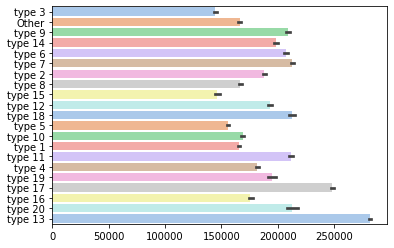

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
types_counts = result.Topic.value_counts()
sns.barplot(x = result.Topic.index, y = result.Topic.values, palette="pastel")
plt.show

In [23]:
result['Lemma_text'] = result['Lemma-text'].apply(lambda row: ' '.join(row))


In [24]:
result = result.drop('Lemma-text', axis=1)

In [25]:
from wordcloud import WordCloud 

In [26]:
def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show() 

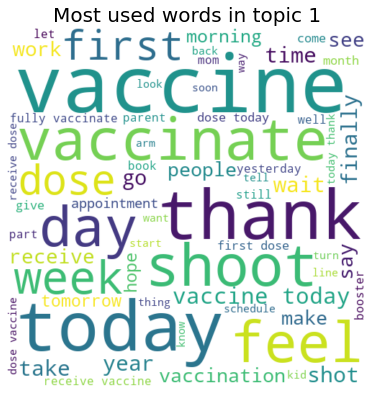

In [27]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 1'], title="Most used words in topic 1")

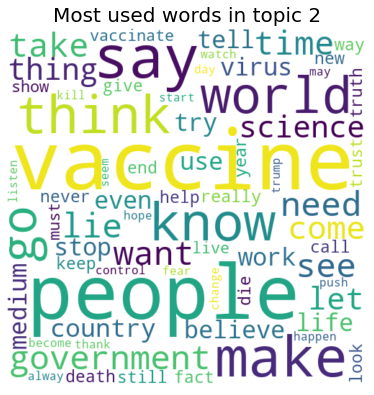

In [28]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 2'], title="Most used words in topic 2")


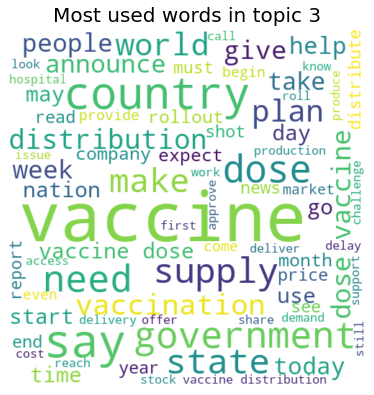

In [29]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 3'], title="Most used words in topic 3")

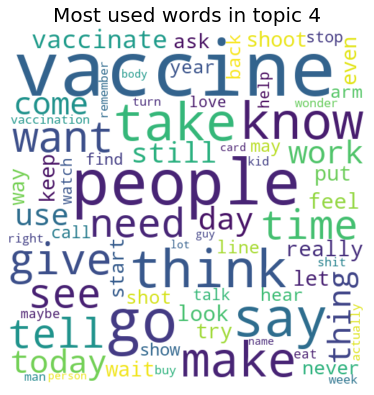

In [30]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 4'], title="Most used words in topic 4")

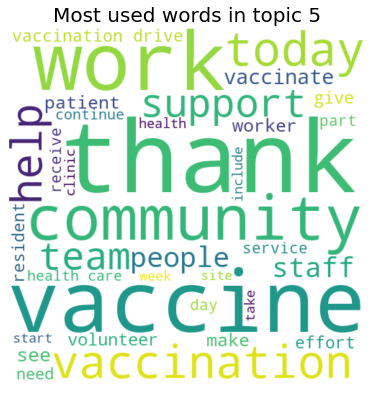

In [31]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 5'], title="Most used words in topic 5")

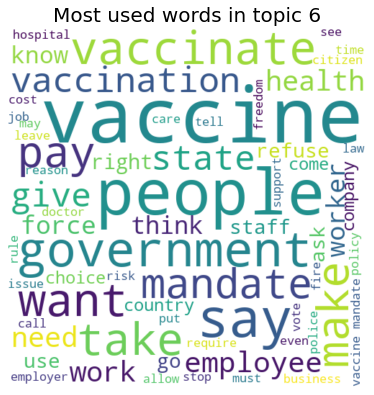

In [32]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 6'], title="Most used words in topic 6")


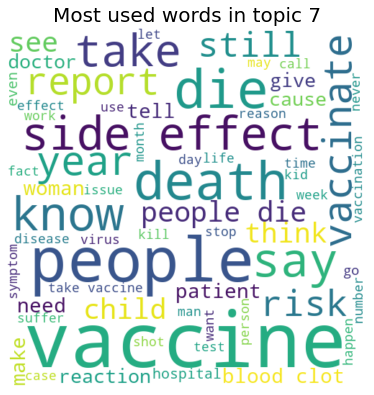

In [33]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 7'], title="Most used words in topic 7")

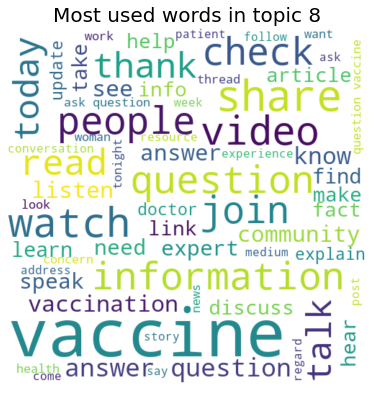

In [34]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 8'], title="Most used words in topic 8")

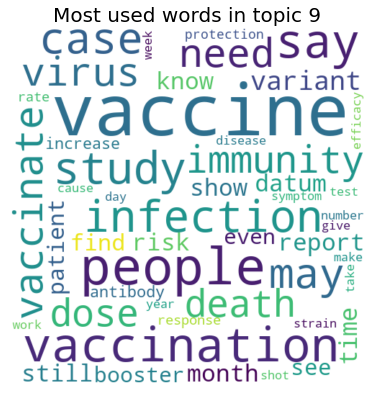

In [35]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 9'], title="Most used words in topic 9")

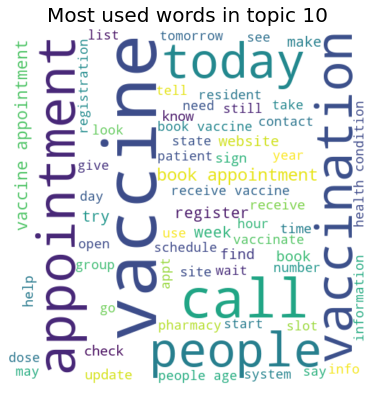

In [36]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 10'], title="Most used words in topic 10")

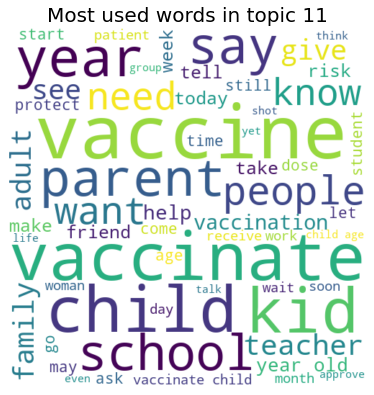

In [37]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 11'], title="Most used words in topic 11")

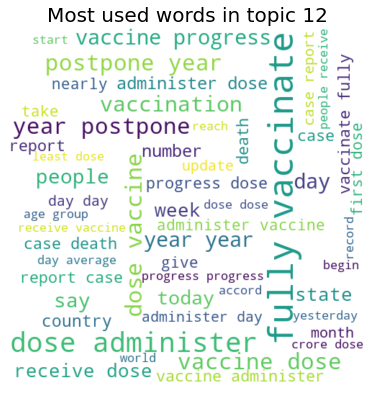

In [38]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 12'], title="Most used words in topic 12")

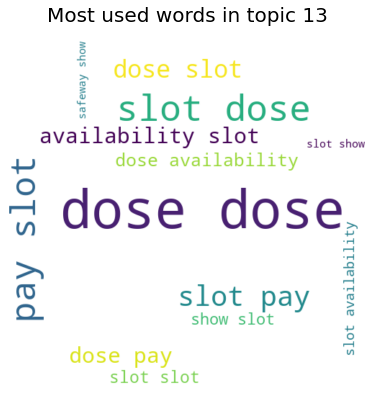

In [39]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 13'], title="Most used words in topic 13")

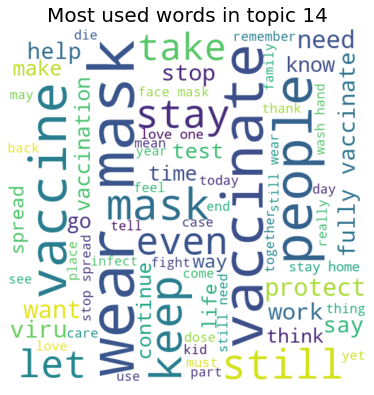

In [40]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 14'], title="Most used words in topic 14")

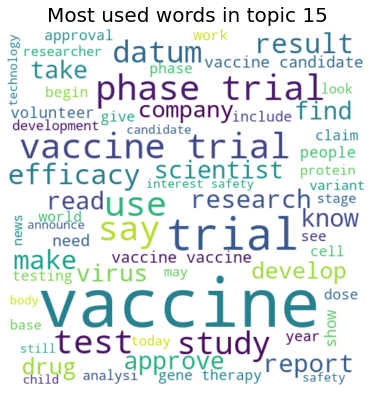

In [41]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 15'], title="Most used words in topic 15")

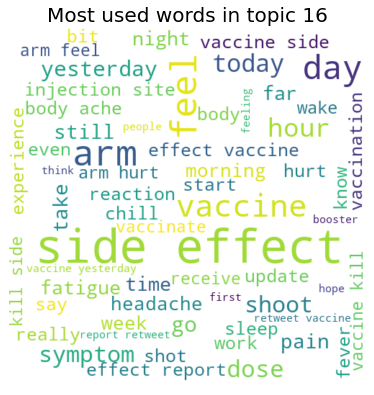

In [42]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 16'], title="Most used words in topic 16")

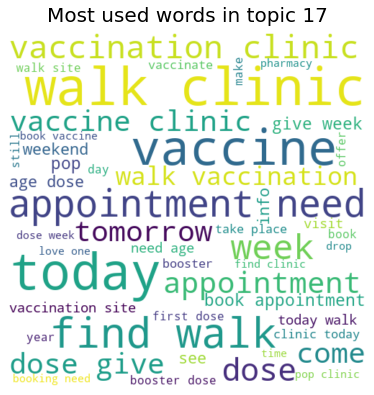

In [43]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 17'], title="Most used words in topic 17")

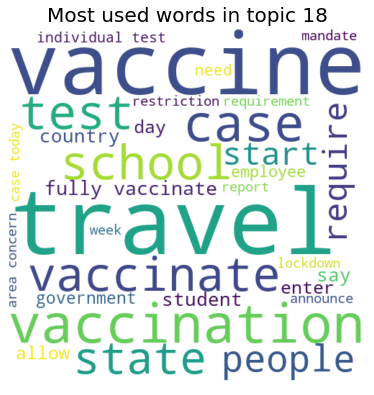

In [44]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 18'], title="Most used words in topic 18")

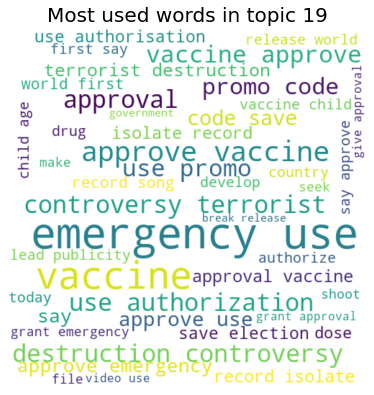

In [45]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 19'], title="Most used words in topic 19")

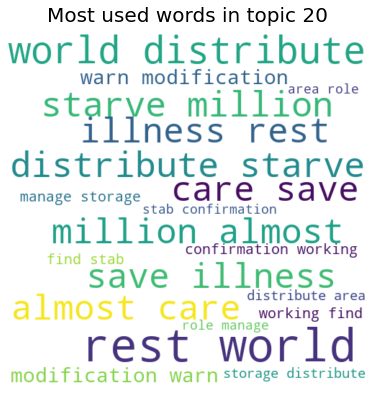

In [46]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 20'], title="Most used words in topic 20")

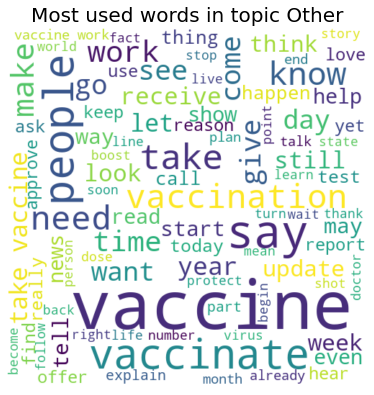

In [62]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'Other'], title="Most used words in topic Other")

In [ ]:
w = gsdmm.score(str(data_lemmatized))
print(w)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## GSDMM Model Iteration

In [47]:
# convert cleaned data to a dataframe
dw = pd.DataFrame(data_lemmatized)
dw.to_csv('gsdmm_cleaned_vaccination_tweet', index=True)

In [48]:
# install libraries
!pip install GPyM-TM

In [51]:
#import the installed library
from GPyM_TM import GSDMM

In [52]:
# assign a filename
filename = 'gsdmm_cleaned_vaccination_tweet'

In [53]:
# load the corpus
corpus = GSDMM.load_file(filename)
corpus[0:5]

[['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '20',
  '21',
  '22',
  '23',
  '24',
  '25',
  '26',
  '27',
  '28'],
 ['0', 'vaccine', 'give', 'citizen', 'cost', 'quote'],
 ['1'],
 ['2', 'death', 'affect', 'country', 'read'],
 ['3', 'stay']]

In [54]:
# choose the number of topics
ntopics = 15

In [55]:
# apply the gsdmm algorithm
data_dmm = GSDMM.DMM(corpus, ntopics)

corpus=368589, words=402557, K=15, a=0.100000, b=0.100000, nTopWords=10, iters=15


In [56]:
# initialize topic assignment
data_dmm.topicAssigmentInitialise()

In [57]:
# train the gsdmm model
data_dmm.inference()

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14


[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]

In [58]:
# calculate word distances
psi, theta, selected_psi, selected_theta = data_dmm.worddist()

In [59]:
# assign topics
finalAssignments = data_dmm.writeTopicAssignments()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [60]:
# write top topical words
coherence_topwords = data_dmm.writeTopTopicalWords(finalAssignments)

education deserve organization today headline banana warn modification ape working 
get vaccine feel effect day arm side today shoot dose 
man shall wax seducer deceive aim controversy develop quickly mean 
get vaccine today vaccinate thank dose do people work take 
pleasurer stream know realm reach laughing face laugh alone truly 
vaccine dose vaccination administer say receive country day state today 
vaccine get people make say take government need vaccination would 
save distribute care world almost illness million rest starve use 
vaccine get appointment vaccination book today dose walk clinic need 
vaccinate case fully death people vaccine vaccination dose get day 
vaccine get people take say know vaccinate make die want 
dose slot pay availability show safeway gap ban appomattox update 
vaccine get vaccination question thank share help community work today 
vaccine trial use say dose study get child datum approve 
year postpone happen world receive twice would person vaxxe world

In [63]:
# calculate coherence score
score = data_dmm.coherence(coherence_topwords, len(finalAssignments))
print("Final number of topics found: " + str(len(finalAssignments)))

average topic:  -56.42314775645046
Final number of topics found: 15
